In [8]:
from utils import load_dataset, get_next_batch
import numpy as np
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset()
print("{} images to train.".format(len(dataset.train.images)))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../data/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


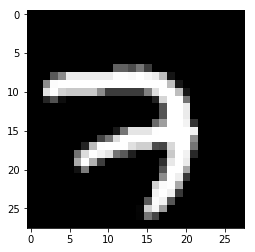

In [3]:
plt.imshow(np.reshape(dataset.train.images[0], (28, 28)), cmap='gray')

In [4]:
import tensorflow as tf
from layers import conv, deconv

In [5]:
from layers import *


def encoder(input):
    # Create a conv network with 3 conv layers and 1 FC layer
    # Conv 1: filter: [3, 3, 1], stride: [2, 2], relu

    conv1 = conv(input, "conv1", [3, 3, 1], [2, 2], padding='SAME')

    # Conv 2: filter: [3, 3, 8], stride: [2, 2], relu

    conv2 = conv(conv1, "conv2", [3, 3, 8], [2, 2], padding='SAME')

    # Conv 3: filter: [3, 3, 8], stride: [2, 2], relu

    conv3 = conv(conv2, "conv3", [3, 3, 8], [2, 2], padding='SAME')

    # FC: output_dim: 100, no non-linearity
    return fc(conv3, "fc", 100, non_linear_fn=None)

def decoder(input):

    # Create a deconv network with 1 FC layer and 3 deconv layers
    # FC: output dim: 128, relu

    fc_de = fc(input, "decode_fc", 128)

    # Reshape to [batch_size, 4, 4, 8]
    fc_de = tf.reshape(fc_de, [-1, 4, 4, 8])

    # Deconv 1: filter: [3, 3, 8], stride: [2, 2], relu

    deconv1 = deconv(fc_de, "deconv1", [3, 3, 8], [2, 2])

    # Deconv 2: filter: [8, 8, 1], stride: [2, 2], padding: valid, relu

    deconv2 = deconv(deconv1, "deconv2", [8, 8, 1], [2, 2], padding='VALID')

    # Deconv 3: filter: [7, 7, 1], stride: [1, 1], padding: valid, sigmoid
    deconv3 = deconv(deconv2, "deconv3", [7, 7, 1], [1, 1], padding='VALID',
                     non_linear_fn=tf.sigmoid)

    return deconv3

def autoencoder(input_shape):
    # Define place holder with input shape
    X = tf.placeholder(tf.float32, input_shape)

    # Define variable scope for autoencoder
    with tf.variable_scope('autoencoder') as scope:
        # Pass input to encoder to obtain encoding
        encoding = encoder(X)

        # Pass encoding into decoder to obtain reconstructed image
        decoding = decoder(encoding)

        # Return input image (placeholder) and reconstructed image
    return X, decoding

In [6]:
batch_size = 100
batch_shape = (batch_size, 28, 28, 1)
num_visualize = 10

lr = 0.001
num_epochs = 100


def calculate_loss(original, reconstructed):
    return tf.reduce_mean(tf.square(reconstructed - original))


def train(dataset):
    input_image, reconstructed_image = autoencoder(batch_shape)
    loss = calculate_loss(input_image, reconstructed_image)
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)

        dataset_size = len(dataset.train.images)
        print("Dataset size:", dataset_size)
        num_iters = (num_epochs * dataset_size) // batch_size
        print("Num iters:", num_iters)
        for step in range(num_iters):
            input_batch = get_next_batch(dataset.train, batch_size)
            loss_val,  _ = session.run([loss, optimizer],
                                       feed_dict={input_image: input_batch})
            if step % 1000 == 0:
                print("Loss at step", step, ":", loss_val)

        test_batch = get_next_batch(dataset.test, batch_size)
        reconstruction = session.run(reconstructed_image,
                                     feed_dict={input_image: test_batch})
        visualize(test_batch, reconstruction, num_visualize)

In [ ]:
tf.reset_default_graph()
train(dataset)

input_dims: [100, 4, 4, 8]
input_dims: [100, 8, 8, 8]
input_dims: [100, 22, 22, 1]
Dataset size: 55000
Num iters: 55000
Loss at step 0 : 0.232763
Loss at step 1000 : 0.073729
Loss at step 2000 : 0.0703369
Loss at step 3000 : 0.0721711
Loss at step 4000 : 0.0516097
Loss at step 5000 : 0.0418827
Loss at step 6000 : 0.040566
